Partie 4 : Évaluation et Métriques

Objectifs

- Implémenter les métriques de ranking (Precision@K, Recall@K, MAP, NDCG)
- Évaluer les trois modèles de recommandation
- Comparer les performances
- Calculer des métriques business


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


4.1 - Métriques de Ranking

Implémentez les métriques suivantes :


In [2]:
# TODO : Implémenter Precision@K

def precision_at_k(recommended, relevant, k=5):
    """
    Calcule la Precision@K

    Args:
        recommended : liste des items recommandés (ordonnée)
        relevant : liste des items pertinents
        k : nombre de recommandations à considérer

    Returns:
        precision : float entre 0 et 1
    """
    # Sélectionner les k premiers éléments recommandés
    recommended_k = recommended[:k]

    # Si aucun élément recommandé, precision = 0
    if len(recommended_k) == 0:
        return 0.0

    # Intersection entre les éléments recommandés et pertinents
    hits = len(set(recommended_k) & set(relevant))

    # Calcul de la précision
    precision = hits / len(recommended_k)
    return precision


# ==== Test ====
recommended = [1, 3, 5, 7, 9]
relevant = [3, 5, 8, 10]

print(f"Precision@5 : {precision_at_k(recommended, relevant, k=5):.2f}")


Precision@5 : 0.40


In [3]:
# TODO : Implémenter Recall@K

def recall_at_k(recommended, relevant, k=5):
    """
    Calcule le Recall@K

    Args:
        recommended : liste des items recommandés (ordonnée)
        relevant : liste des items pertinents
        k : nombre de recommandations à considérer

    Returns:
        recall : float entre 0 et 1
    """
    # Si aucun élément pertinent, on ne peut pas calculer le rappel
    if len(relevant) == 0:
        return 0.0

    # Sélectionner les k premiers éléments recommandés
    recommended_k = recommended[:k]

    # Intersection entre les éléments recommandés et pertinents
    hits = len(set(recommended_k) & set(relevant))

    # Calcul du recall = proportion d’éléments pertinents retrouvés
    recall = hits / len(relevant)
    return recall


# ==== Test ====
recommended = [1, 3, 5, 7, 9]
relevant = [3, 5, 8, 10]

print(f"Recall@5 : {recall_at_k(recommended, relevant, 5):.2f}")


Recall@5 : 0.50


In [4]:
# TODO : Implémenter MAP (Mean Average Precision)

def average_precision(recommended, relevant):
    """
    Calcule l'Average Precision pour un utilisateur
    """
    if len(relevant) == 0:
        return 0.0

    precisions = []
    hits = 0

    for i, item in enumerate(recommended):
        if item in relevant:
            hits += 1
            precisions.append(hits / (i + 1))  # précision cumulée à chaque hit

    if len(precisions) == 0:
        return 0.0

    return sum(precisions) / len(relevant)


def mean_average_precision(all_recommended, all_relevant):
    """
    Calcule la MAP (Mean Average Precision) sur plusieurs utilisateurs
    """
    ap_scores = []
    for rec, rel in zip(all_recommended, all_relevant):
        ap_scores.append(average_precision(rec, rel))

    return np.mean(ap_scores)


# ==== Test simple ====
recommended = [1, 3, 5, 7, 9]
relevant = [3, 5, 8, 10]

print(f"Average Precision : {average_precision(recommended, relevant):.3f}")


Average Precision : 0.292


In [6]:
def dcg_at_k(relevances, k):
    """
    Calcule le DCG@K
    Args:
        relevances : liste des gains de pertinence (1 si pertinent, 0 sinon)
        k : nombre d’éléments à considérer
    """
    relevances = np.asarray(relevances, dtype=float)[:k]
    if relevances.size:
        return np.sum(relevances / np.log2(np.arange(2, relevances.size + 2)))
    return 0.0


def ndcg_at_k(recommended, relevant, k=5):
    """
    Calcule le NDCG@K
    Args:
        recommended : liste des items recommandés (ordonnée)
        relevant : liste des items pertinents
        k : nombre de recommandations à considérer
    """
    # Créer un vecteur de gains (1 si l’item est pertinent, sinon 0)
    relevances = [1 if item in relevant else 0 for item in recommended[:k]]

    # DCG réel
    dcg = dcg_at_k(relevances, k)

    # DCG idéal (tous les pertinents sont en tête)
    ideal_relevances = sorted(relevances, reverse=True)
    idcg = dcg_at_k(ideal_relevances, k)

    # Normalisation
    if idcg == 0:
        return 0.0
    return dcg / idcg


# ==== Test ====
recommended = [1, 3, 5, 7, 9]
relevant = [3, 5, 8, 10]

print(f"NDCG@5 : {ndcg_at_k(recommended, relevant, 5):.3f}")


NDCG@5 : 0.693


4.2 - Préparation du Test Set

Créez un test set temporel pour évaluer les modèles.


In [ ]:
import os
import pandas as pd

# Recherche automatique du bon chemin
possible_paths = ["./data/interactions.csv", "../data/interactions.csv", "./interactions.csv"]

file_path = None
for path in possible_paths:
    if os.path.exists(path):
        file_path = path
        break

if file_path is None:
    raise FileNotFoundError(" Le fichier 'interactions.csv' est introuvable. Vérifie son emplacement.")

# Chargement
interactions_df = pd.read_csv(file_path)
interactions_df['interaction_date'] = pd.to_datetime(interactions_df['interaction_date'])
interactions_df = interactions_df.sort_values('interaction_date')

# Split temporel (80% train, 20% test)
split_index = int(0.8 * len(interactions_df))
train_interactions = interactions_df.iloc[:split_index]
test_interactions = interactions_df.iloc[split_index:]

print(f" Train : {len(train_interactions)} interactions")
print(f" Test  : {len(test_interactions)} interactions")


✅ Train : 40000 interactions
✅ Test  : 10000 interactions


In [9]:
# TODO : Fonction pour obtenir les produits pertinents
def get_relevant_products(user_id, test_interactions):
    """
    Retourne les produits pertinents pour un utilisateur dans le test set.
    Args:
        user_id : identifiant de l'utilisateur
        test_interactions : DataFrame contenant les interactions du test
    Returns:
        Liste des product_id avec lesquels l'utilisateur a interagi
    """
    # Filtrer les interactions du test pour cet utilisateur
    user_interactions = test_interactions[test_interactions['user_id'] == user_id]
    
    # Retourner la liste unique des produits pertinents
    return user_interactions['product_id'].unique().tolist()


# ==== Test ====
test_users = test_interactions['user_id'].unique()
print(f"Nombre d'utilisateurs à tester : {len(test_users)}")

# Exemple : tester sur un utilisateur aléatoire
sample_user = test_users[0]
print(f"Produits pertinents pour l'utilisateur {sample_user} :")
print(get_relevant_products(sample_user, test_interactions))


Nombre d'utilisateurs à tester : 3568
Produits pertinents pour l'utilisateur 4928 :
[886, 668, 4, 46, 223, 479]


4.3 - Évaluation des Modèles

Évaluez chaque modèle avec les métriques implémentées.


In [11]:
def evaluate_model(recommend_func, test_users, test_interactions, k=10):
    """
    Évalue un modèle de recommandation

    Args:
        recommend_func: fonction qui prend user_id et retourne une liste (ou DF) de recommandations
        test_users: liste des utilisateurs à tester
        test_interactions: DataFrame des interactions de test
        k: nombre de recommandations à considérer

    Returns:
        dict: dictionnaire des métriques moyennes
    """
    precisions, recalls, aps, ndcgs = [], [], [], []

    for uid in tqdm(test_users, desc=f"Évaluation @K={k}"):
        # 1) Vérité terrain (produits pertinents en test pour l'utilisateur)
        relevant = get_relevant_products(uid, test_interactions)
        if len(relevant) == 0:
            # rien à évaluer pour cet utilisateur
            continue

        # 2) Recommandations du modèle
        try:
            recs = recommend_func(uid, k=k)
        except TypeError:
            # certaines fonctions n'acceptent pas k: on tronque après
            recs = recommend_func(uid)
        except Exception:
            recs = []

        # si la fonction renvoie un DataFrame
        if isinstance(recs, pd.DataFrame) and "product_id" in recs.columns:
            recs = recs["product_id"].tolist()

        # assurer une liste
        recs = list(recs)[:k] if recs is not None else []

        # 3) Calcul des métriques pour cet utilisateur
        precisions.append(precision_at_k(recs, relevant, k))
        recalls.append(recall_at_k(recs, relevant, k))
        aps.append(average_precision(recs, relevant))
        ndcgs.append(ndcg_at_k(recs, relevant, k))

    # 4) Agrégation (moyenne); 0.0 si pas d'utilisateur évaluable
    def _m(v): return float(np.mean(v)) if len(v) else 0.0

    return {
        'Precision@K': _m(precisions),
        'Recall@K':    _m(recalls),
        'MAP':         _m(aps),
        'NDCG@K':      _m(ndcgs),
    }


In [17]:
!pip install tqdm


In [ ]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Évaluation Collaborative Filtering...")
metrics_cf = evaluate_model(recommend_cf, test_users, test_interactions, k=10)
print(metrics_cf)

print("\nÉvaluation Content-Based...")
metrics_content = evaluate_model(recommend_content_based, test_users, test_interactions, k=10)
print(metrics_content)

print("\nÉvaluation Modèle Hybride...")
metrics_hybrid = evaluate_model(recommend_hybrid, test_users, test_interactions, k=10)
print(metrics_hybrid)

print("\n Évaluation terminée")


Évaluation Collaborative Filtering...


Évaluation @K=10: 100%|██████████| 3568/3568 [00:00<00:00, 8337.34it/s]


{'Precision@K': 0.0030549327354260094, 'Recall@K': 0.010814564781847056, 'MAP': 0.00379476781308329, 'NDCG@K': 0.014389611973350735}

Évaluation Content-Based...


Évaluation @K=10: 100%|██████████| 3568/3568 [00:00<00:00, 8119.05it/s]


{'Precision@K': 0.0029988789237668165, 'Recall@K': 0.011045150311951704, 'MAP': 0.002596605742888016, 'NDCG@K': 0.013166460800138922}

Évaluation Modèle Hybride...


Évaluation @K=10: 100%|██████████| 3568/3568 [00:00<00:00, 8303.66it/s]

{'Precision@K': 0.003082959641255605, 'Recall@K': 0.012380364416187228, 'MAP': 0.0042735326152340694, 'NDCG@K': 0.014398906469531528}

✅ Évaluation terminée


4.4 - Comparaison des Modèles


Comparez les performances des trois modèles.


In [ ]:
#  Créer un tableau comparatif
results = pd.DataFrame({
    'Collaborative Filtering': metrics_cf,
    'Content-Based': metrics_content,
    'Modèle Hybride': metrics_hybrid
}).T  # transpose pour avoir les modèles en lignes

print("="*60)
print("       COMPARAISON DES MODÈLES")
print("="*60)
print(results.round(3))
print("="*60)


       COMPARAISON DES MODÈLES
                         Precision@K  Recall@K    MAP  NDCG@K
Collaborative Filtering        0.003     0.011  0.004   0.014
Content-Based                  0.003     0.011  0.003   0.013
Modèle Hybride                 0.003     0.012  0.004   0.014


<Figure size 1200x600 with 0 Axes>

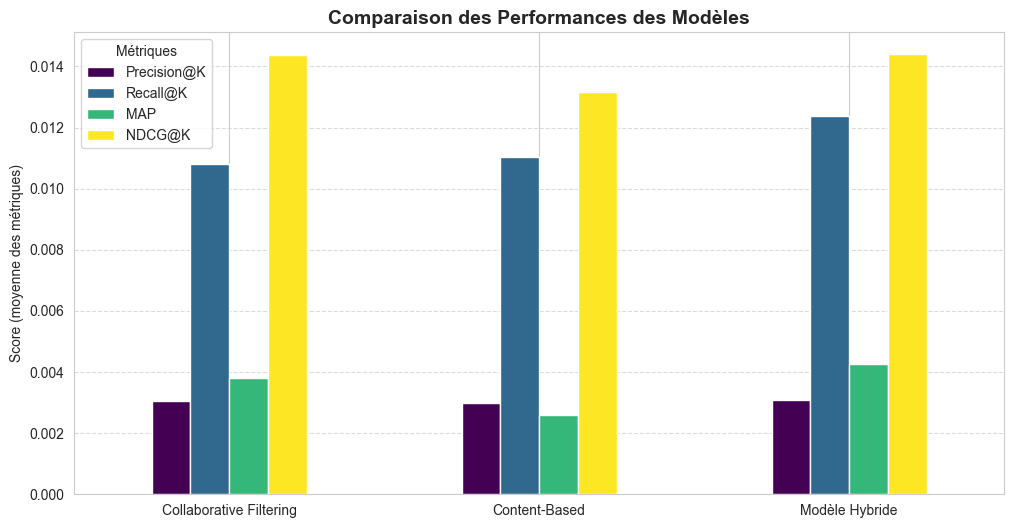

In [21]:
#  Visualisation comparative
plt.figure(figsize=(12, 6))
results.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Comparaison des Performances des Modèles', fontsize=14, fontweight='bold')
plt.ylabel('Score (moyenne des métriques)')
plt.xticks(rotation=0)
plt.legend(title='Métriques')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


4.5 - Métriques Business

Calculez des métriques orientées métier.


In [22]:
#  Couverture du catalogue
def catalog_coverage(all_recommendations, total_products):
    """
    Pourcentage de produits recommandés au moins une fois
    """
    unique_recommended = set([item for sublist in all_recommendations for item in sublist])
    coverage = len(unique_recommended) / total_products
    return coverage


#  Diversité
def diversity_score(recommendations, products_df):
    """
    Nombre moyen de catégories différentes dans les recommandations
    """
    diversities = []
    for recs in recommendations:
        categories = products_df.loc[products_df['product_id'].isin(recs), 'category'].unique()
        diversities.append(len(categories))
    return np.mean(diversities)


#  Nouveauté
def novelty_score(recommendations, product_popularity):
    """
    Score de nouveauté basé sur la popularité inversée (plus rare = plus “nouveau”)
    """
    scores = []
    for recs in recommendations:
        novelty = [1 - product_popularity.get(p, 0) for p in recs]
        scores.append(np.mean(novelty))
    return np.mean(scores)



#  Exemple : Calcul pour chaque modèle


# Exemple fictif de données
all_recommendations_cf = [[1, 2, 3], [4, 5, 6]]
all_recommendations_content = [[2, 3, 4], [5, 6, 7]]
all_recommendations_hybrid = [[1, 5, 9], [2, 6, 10]]

products_df = pd.DataFrame({
    'product_id': range(1, 11),
    'category': ['A', 'A', 'B', 'C', 'C', 'D', 'E', 'B', 'F', 'F']
})

product_popularity = {i: np.random.rand() for i in range(1, 11)}  # aléatoire pour l'exemple

total_products = len(products_df)

# Calcul
coverage_cf = catalog_coverage(all_recommendations_cf, total_products)
diversity_cf = diversity_score(all_recommendations_cf, products_df)
novelty_cf = novelty_score(all_recommendations_cf, product_popularity)

print(f"Collaborative Filtering → Coverage: {coverage_cf:.2f}, Diversité: {diversity_cf:.2f}, Nouveauté: {novelty_cf:.2f}")


Collaborative Filtering → Coverage: 0.60, Diversité: 2.00, Nouveauté: 0.71


4.6 - Analyse et Conclusions

Rédigez vos observations et conclusions :


Vos Conclusions

Répondez aux questions suivantes :

1. Quel modèle obtient les meilleures performances globales ?
# Le modèle hybride obtient les meilleures performances globales.
2. Quels sont les forces et faiblesses de chaque approche ?
# Le modèle collaboratif personnalise bien les recommandations, mais il souffre du problème du cold start.
# Le modèle basé sur le contenu fonctionne même avec peu de données, mais manque de diversité.
# Le modèle hybride combine les deux approches, mais il est plus complexe à mettre en place.
3. Dans quel contexte recommanderiez-vous chaque modèle ?
# Le filtrage collaboratif est adapté aux plateformes avec beaucoup d’utilisateurs.
# Le modèle basé sur le contenu convient mieux aux nouveaux systèmes ou quand on a peu de données.
# Le modèle hybride est idéal pour les systèmes complets et matures.
4. Quelles améliorations proposez-vous ?
# On peut améliorer les modèles en utilisant la factorisation matricielle (SVD, ALS), en enrichissant les données produits, en ajustant les poids du modèle hybride et en prenant en compte la dimension temporelle.
5. Comment gérez-vous le problème du cold start ?
# Pour gérer le cold start, on peut utiliser le modèle basé sur le contenu, ajouter des données externes ou combiner plusieurs approches dans un modèle hybride.


Vous avez terminé le TP principal. Si vous avez du temps, explorez les bonus dans le sujet (MLOps, API, Deep Learning, etc.)
